In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
np.sqrt(-1+0j)
np.sqrt(-1) # doesn't work since the input is of type float which corresponds to a real value (not complex)

/home/seongjin/HazaPython/venv01/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


nan

In [3]:
def get_k(energy, constant_potential):
    m, hbar = 1.0, 1.0  # using atomic unit
    E, V0 = energy, constant_potential  # aliasing for convenience
    k = np.sqrt(2*m*(E-V0)+0j) / hbar
    return k

def f(x, energy, constant_potential):
    k = get_k(energy, constant_potential)
    f_val = np.exp(1.0j * k * x)
    return f_val, k
    
# def df(x, energy, constant_potential):
#     k = get_k(energy, constant_potential)
#     f_val = f(x, energy, constant_potential)
#     df_val = f_val * 1.0j * k
#     return df_val

In [4]:
from numbers import Integral

def sol(x, energy, constant_potential, sol_index, diff_number):
    for int_args in [sol_index, diff_number]: assert isinstance(int_args, Integral)
    assert sol_index in [1, 2]
    assert diff_number >= 0
    
    f_val, k = f(x, energy, constant_potential)
    f_val *= (1.0j * k) ** diff_number
    if sol_index == 2: f_val **= -1
    return f_val

In [5]:
from numbers import Number

def W(x, energy, constant_potential):
    assert isinstance(x, Number)
    wronskian = np.empty((2,2), dtype=complex)
    for idx0, diff_number in enumerate([0,1]):
        for idx1, sol_index in enumerate([1,2]):
            wronskian[idx0, idx1] = sol(x, energy, constant_potential, sol_index, diff_number)
    return wronskian

In [6]:
W(1.0, 0.6, 0.5)

array([[ 0.9016556 +0.43245484j,  0.9016556 -0.43245484j],
       [-0.19339968+0.40323264j, -0.96699842-2.0161632j ]])

### Test plotting

In [7]:
x = np.linspace(-2,2,100)

In [8]:
f_val, k = f(x, 0.6, 1.0)
# df_val = df(x, 0.6, 1.0)
f_val_sol = sol(x, 0.6, 1.0, 1, 0)

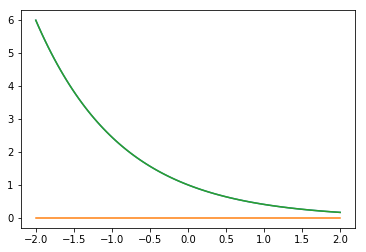

In [9]:
fig, ax = plt.subplots()
ax.plot(x,f_val.real)
# ax.plot(x,df_val.real)
ax.plot(x,f_val.imag)
ax.plot(x,f_val_sol.real)

# Step potential

### Set free variable

In [10]:
A2, B2 = 1, 0

In [11]:
E, V0 = 1.5, 1.0

In [12]:
x_alpha = 0.4

In [13]:
W1 = W(x_alpha, E, 0.0)
W2 = W(x_alpha, E, V0)

In [14]:
b = W2 @ [A2, B2]

In [15]:
A1, B1 = np.linalg.solve(W1, b)

In [16]:
x_arr = np.linspace(-15,15,1000)
x_1 = x_arr[x_arr < x_alpha]
x_2 = x_arr[x_arr >= x_alpha]

In [17]:
psi_1 = A1 * sol(x_1, E, 0.0, 1, 0) + B1 * sol(x_1, E, 0.0, 2, 0)
psi_2 = A2 * sol(x_2, E, V0, 1, 0) + B2 * sol(x_2, E, V0, 2, 0)

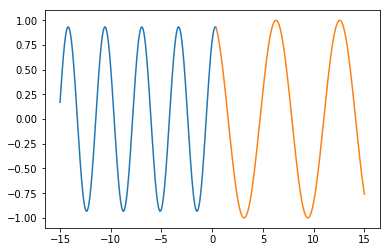

In [18]:
fig, ax = plt.subplots()
ax.plot(x_1, psi_1.real)
ax.plot(x_2, psi_2.real)

In [19]:
#fig.savefig('step-pot-using-wronskian-A2-1-B2-0.png')